# Featurization (hCRISPRi v2)

This notebook is intended to featurize the data associated with human CRISPRi activity scores to make it easier to train a linear regression model to. In particular, we are featurizing the hCRISPRi v2 library.

The data used is that from the following paper:

[Compact and highly active next-generation libraries for CRISPR-mediated gene repression and activation](https://elifesciences.org/articles/19760)

__Primary Author__: Anthony Hein

__Contributors__: Based off of a notebook (Featurization.ipynb) for which Briana Macedo was an equal contributor.

---

# Notebook Setup

In [210]:
# dataframes
import pandas as pd

# arrays
import numpy as np

# plotting
import matplotlib.pyplot as plt

# regression & support vector machine
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [211]:
# random seed
np.random.seed(0)

# plotting
%matplotlib inline

---

# Data Imports and Checks

In [212]:
# read csvs into dfs & inspect
library_df = pd.read_csv('hCRISPRi_Library_v2.csv')
tss_annotation_df = pd.read_csv('TSS_Annotations.csv')

### Activity Score Dataframe Checks

In [213]:
library_df.head()

,sgID,gene,transcript,protospacer sequence,selection rank,predicted score,empirical score,off-target stringency,CRISPRi-v2.1 predicted score,Sublibrary,Sublibrary half
0,A1BG_-_58858617.23-P1,A1BG,P1,GGAGACCCAGCGCTAACCAG,1.0,1.008816,NaN,0,0.685071,h3,Top5
1,A1BG_-_58858788.23-P1,A1BG,P1,GGGGCACCCAGGAGCGGTAG,2.0,0.901176,NaN,0,0.782793,h3,Top5
2,A1BG_+_58858964.23-P1,A1BG,P1,GCTCCGGGCGACGTGGAGTG,3.0,0.836188,NaN,0,0.870837,h3,Top5
3,A1BG_-_58858630.23-P1,A1BG,P1,GAACCAGGGGTGCCCAAGGG,4.0,0.827551,NaN,0,0.590668,h3,Top5
4,A1BG_+_58858549.23-P1,A1BG,P1,GGCGAGGAACCGCCCAGCAA,5.0,0.775395,NaN,0,0.492280,h3,Top5


In [214]:
library_df = library_df.drop(columns=[
    'empirical score', 
    'gene', 
    'transcript', 
    'selection rank', 
    'Sublibrary', 
    'Sublibrary half',
    'off-target stringency'
])
library_df.head()

,sgID,protospacer sequence,predicted score,CRISPRi-v2.1 predicted score
0,A1BG_-_58858617.23-P1,GGAGACCCAGCGCTAACCAG,1.008816,0.685071
1,A1BG_-_58858788.23-P1,GGGGCACCCAGGAGCGGTAG,0.901176,0.782793
2,A1BG_+_58858964.23-P1,GCTCCGGGCGACGTGGAGTG,0.836188,0.870837
3,A1BG_-_58858630.23-P1,GAACCAGGGGTGCCCAAGGG,0.827551,0.590668
4,A1BG_+_58858549.23-P1,GGCGAGGAACCGCCCAGCAA,0.775395,0.492280


In [215]:
library_df = library_df.dropna().reset_index().drop(columns=['index'])
library_df.head()

,sgID,protospacer sequence,predicted score,CRISPRi-v2.1 predicted score
0,A1BG_-_58858617.23-P1,GGAGACCCAGCGCTAACCAG,1.008816,0.685071
1,A1BG_-_58858788.23-P1,GGGGCACCCAGGAGCGGTAG,0.901176,0.782793
2,A1BG_+_58858964.23-P1,GCTCCGGGCGACGTGGAGTG,0.836188,0.870837
3,A1BG_-_58858630.23-P1,GAACCAGGGGTGCCCAAGGG,0.827551,0.590668
4,A1BG_+_58858549.23-P1,GGCGAGGAACCGCCCAGCAA,0.775395,0.492280


In [216]:
tmp = pd.DataFrame(library_df['sgID'].str.split('_').tolist())
tmp.head()

,0,1,2,3,4,5
0,A1BG,-,58858617.23-P1,None,None,None
1,A1BG,-,58858788.23-P1,None,None,None
2,A1BG,+,58858964.23-P1,None,None,None
3,A1BG,-,58858630.23-P1,None,None,None
4,A1BG,+,58858549.23-P1,None,None,None


The existence of columns 3, 4, and 5 indicate that string split fails in some positions. We will remove these positions from the dataframe. Any position where it fails will have a non-null column 3.

In [217]:
tmp_concat = pd.concat([library_df, tmp], axis=1)
tmp_concat = tmp_concat[tmp_concat[3].isnull()]
tmp_concat = tmp_concat.reset_index()
tmp_concat = tmp_concat.drop(columns=['index', 'sgID', 3, 4, 5])
tmp_concat.columns = tmp_concat.columns[0:-3].tolist() + ['gene', 'strand', 'coord-length-trans']
tmp_concat

,protospacer sequence,predicted score,CRISPRi-v2.1 predicted score,gene,strand,coord-length-trans
0,GGAGACCCAGCGCTAACCAG,1.008816,0.685071,A1BG,-,58858617.23-P1
1,GGGGCACCCAGGAGCGGTAG,0.901176,0.782793,A1BG,-,58858788.23-P1
2,GCTCCGGGCGACGTGGAGTG,0.836188,0.870837,A1BG,+,58858964.23-P1
3,GAACCAGGGGTGCCCAAGGG,0.827551,0.590668,A1BG,-,58858630.23-P1
4,GGCGAGGAACCGCCCAGCAA,0.775395,0.492280,A1BG,+,58858549.23-P1
...,...,...,...,...,...,...
198844,GGACCCACCTGGAAGCGCCG,0.851347,0.796605,ZZZ3,+,78149066.23-P1P2
198845,GTCCACTAGACCCAACATGG,0.850643,0.639875,ZZZ3,-,78148422.23-P1P2
198846,GTGTGCGCGGGCGAAAGGGG,0.807459,0.567739,ZZZ3,+,78148719.23-P1P2
198847,GGATTCTCGCGGGACCTCGT,0.799355,0.718886,ZZZ3,+,78148338.23-P1P2


In [218]:
tmp[tmp[3].notnull()]

,0,1,2,3,4,5
8650,APOBEC3A,B,-,39353686.23-P1P2,None,None
8651,APOBEC3A,B,-,39353663.23-P1P2,None,None
8652,APOBEC3A,B,-,39353659.23-P1P2,None,None
8653,APOBEC3A,B,-,39354013.23-P1P2,None,None
8654,APOBEC3A,B,+,39354066.23-P1P2,None,None
...,...,...,...,...,...,...
197690,ZNF735,-,63667917.23-NM,001159524,None,None
197691,ZNF735,+,63667937.23-NM,001159524,None,None
197692,ZNF735,+,63667765.23-NM,001159524,None,None
197693,ZNF735,-,63667849.23-NM,001159524,None,None


In [219]:
library_df = tmp_concat

In [220]:
tmp = pd.DataFrame(library_df['coord-length-trans'].str.split('.').tolist())
tmp.head()

,0,1,2,3,4,5,6
0,58858617,23-P1,None,None,None,None,None
1,58858788,23-P1,None,None,None,None,None
2,58858964,23-P1,None,None,None,None,None
3,58858630,23-P1,None,None,None,None,None
4,58858549,23-P1,None,None,None,None,None


In [221]:
tmp_concat = pd.concat([library_df, tmp], axis=1)
tmp_concat = tmp_concat[tmp_concat[2].isnull()]
tmp_concat = tmp_concat.reset_index()
tmp_concat = tmp_concat.drop(columns=['index', 'coord-length-trans', 2, 3, 4, 5, 6])
tmp_concat.columns = tmp_concat.columns[0:-2].tolist() + ['coordinate', 'length-trans']
tmp_concat

,protospacer sequence,predicted score,CRISPRi-v2.1 predicted score,gene,strand,coordinate,length-trans
0,GGAGACCCAGCGCTAACCAG,1.008816,0.685071,A1BG,-,58858617,23-P1
1,GGGGCACCCAGGAGCGGTAG,0.901176,0.782793,A1BG,-,58858788,23-P1
2,GCTCCGGGCGACGTGGAGTG,0.836188,0.870837,A1BG,+,58858964,23-P1
3,GAACCAGGGGTGCCCAAGGG,0.827551,0.590668,A1BG,-,58858630,23-P1
4,GGCGAGGAACCGCCCAGCAA,0.775395,0.492280,A1BG,+,58858549,23-P1
...,...,...,...,...,...,...,...
183518,GGACCCACCTGGAAGCGCCG,0.851347,0.796605,ZZZ3,+,78149066,23-P1P2
183519,GTCCACTAGACCCAACATGG,0.850643,0.639875,ZZZ3,-,78148422,23-P1P2
183520,GTGTGCGCGGGCGAAAGGGG,0.807459,0.567739,ZZZ3,+,78148719,23-P1P2
183521,GGATTCTCGCGGGACCTCGT,0.799355,0.718886,ZZZ3,+,78148338,23-P1P2


In [222]:
library_df = tmp_concat

In [223]:
tmp = pd.DataFrame(library_df['length-trans'].str.split('-').tolist())
tmp.head()

,0,1
0,23,P1
1,23,P1
2,23,P1
3,23,P1
4,23,P1


In [224]:
tmp_concat = pd.concat([library_df, tmp], axis=1)
tmp_concat = tmp_concat.drop(columns=['length-trans', 1])
tmp_concat.columns = tmp_concat.columns[0:-1].tolist() + ['length']
tmp_concat

,protospacer sequence,predicted score,CRISPRi-v2.1 predicted score,gene,strand,coordinate,length
0,GGAGACCCAGCGCTAACCAG,1.008816,0.685071,A1BG,-,58858617,23
1,GGGGCACCCAGGAGCGGTAG,0.901176,0.782793,A1BG,-,58858788,23
2,GCTCCGGGCGACGTGGAGTG,0.836188,0.870837,A1BG,+,58858964,23
3,GAACCAGGGGTGCCCAAGGG,0.827551,0.590668,A1BG,-,58858630,23
4,GGCGAGGAACCGCCCAGCAA,0.775395,0.492280,A1BG,+,58858549,23
...,...,...,...,...,...,...,...
183518,GGACCCACCTGGAAGCGCCG,0.851347,0.796605,ZZZ3,+,78149066,23
183519,GTCCACTAGACCCAACATGG,0.850643,0.639875,ZZZ3,-,78148422,23
183520,GTGTGCGCGGGCGAAAGGGG,0.807459,0.567739,ZZZ3,+,78148719,23
183521,GGATTCTCGCGGGACCTCGT,0.799355,0.718886,ZZZ3,+,78148338,23


In [225]:
library_df = tmp_concat

### TSS Annotation Dataframe Checks

In [226]:
tss_annotation_df.head()

,gene,transcript,chromosome,strand,TSS source,"Primary TSS, 5'","Primary TSS, 3'","Secondary TSS, 5'","Secondary TSS, 3'"
0,A1BG,P1,chr19,-,"CAGE, matched peaks",58858938,58859039,58858938,58859039
1,A1BG,P2,chr19,-,"CAGE, matched peaks",58864822,58864847,58864822,58864847
2,A1CF,P1P2,chr10,-,"CAGE, matched peaks",52645379,52645393,52645379,52645393
3,A2M,P1P2,chr12,-,"CAGE, matched peaks",9268507,9268523,9268528,9268542
4,A2ML1,P1P2,chr12,+,"CAGE, matched peaks",8975206,8975223,8975144,8975169


### Column Renaming (for convenience)

In [227]:
new_colnames = {
    "protospacer sequence" : "sequence",
    "predicted score" : "predicted score v2",
    "CRISPRi-v2.1 predicted score" : "predicted score v2.1"
}
library_df = library_df.rename(columns=new_colnames)
library_df.head()

,sequence,predicted score v2,predicted score v2.1,gene,strand,coordinate,length
0,GGAGACCCAGCGCTAACCAG,1.008816,0.685071,A1BG,-,58858617,23
1,GGGGCACCCAGGAGCGGTAG,0.901176,0.782793,A1BG,-,58858788,23
2,GCTCCGGGCGACGTGGAGTG,0.836188,0.870837,A1BG,+,58858964,23
3,GAACCAGGGGTGCCCAAGGG,0.827551,0.590668,A1BG,-,58858630,23
4,GGCGAGGAACCGCCCAGCAA,0.775395,0.492280,A1BG,+,58858549,23


In [228]:
new_colnames = {
    "TSS source" : "source",
    "Primary TSS, 5'" : "prim 5'",
    "Primary TSS, 3'" : "prim 3'",
    "Secondary TSS, 5'" : "snd 5'",
    "Secondary TSS, 3'" : "snd 3'"
}
tss_annotation_df = tss_annotation_df.rename(columns=new_colnames)
tss_annotation_df.head()

,gene,transcript,chromosome,strand,source,prim 5',prim 3',snd 5',snd 3'
0,A1BG,P1,chr19,-,"CAGE, matched peaks",58858938,58859039,58858938,58859039
1,A1BG,P2,chr19,-,"CAGE, matched peaks",58864822,58864847,58864822,58864847
2,A1CF,P1P2,chr10,-,"CAGE, matched peaks",52645379,52645393,52645379,52645393
3,A2M,P1P2,chr12,-,"CAGE, matched peaks",9268507,9268523,9268528,9268542
4,A2ML1,P1P2,chr12,+,"CAGE, matched peaks",8975206,8975223,8975144,8975169


### Transform Data (for convenience)

In [229]:
# capitalize all sequences
library_df['sequence'] = library_df['sequence'].str.upper()

# map strands {-, +} --> {0, 1}
library_df['+ve strand'] = (library_df['strand'] == '+').astype('int')

# as integer
library_df['coordinate'] = library_df['coordinate'].astype('int')

# as integer
library_df['length'] = library_df['length'].astype('int')

In [230]:
library_df.head()

,sequence,predicted score v2,predicted score v2.1,gene,strand,coordinate,length,+ve strand
0,GGAGACCCAGCGCTAACCAG,1.008816,0.685071,A1BG,-,58858617,23,0
1,GGGGCACCCAGGAGCGGTAG,0.901176,0.782793,A1BG,-,58858788,23,0
2,GCTCCGGGCGACGTGGAGTG,0.836188,0.870837,A1BG,+,58858964,23,1
3,GAACCAGGGGTGCCCAAGGG,0.827551,0.590668,A1BG,-,58858630,23,0
4,GGCGAGGAACCGCCCAGCAA,0.775395,0.492280,A1BG,+,58858549,23,1


### Cross-Check the Dataframes

During our analysis, we realized the following:

Genes in `tss_annotation_df` may _not_ be unique. Rather, the product of a gene and a transcript is unique. However, there is no transcript information contained within `activity_score_df`. For this reason, if a gene appears in `activity_score_df` that does not correspond to a unique gene in `tss_annotation_df`, it becomes ambiguous which one to use. Given that these constitute a relatively small set, we have chosen to remove these from `activity_score_df`.

A gene in `activity_score_df` may not have an annotation in `tss_annotation_df`. Once again, these constitute a small set, so we remove them.
The following cells implement these fixes.

_NB: A future iteration of this notebook might find ways to better address these ambiguities._

In [231]:
# genes are duplicated in tss_annotation_df
annot_genes_dup_vec = tss_annotation_df['gene'].duplicated()
print(str(sum(annot_genes_dup_vec)) + " genes are duplicated in tss_annotation_df")

1694 genes are duplicated in tss_annotation_df


In [232]:
# the set of duplicated genes
annot_genes_dup = tss_annotation_df['gene'][annot_genes_dup_vec].unique()
print("The following are some of the genes duplicated in tss_annotation_df: " + str(annot_genes_dup[0:5]))

The following are some of the genes duplicated in tss_annotation_df: ['A1BG' 'AARSD1' 'ABAT' 'ABCA7' 'ABCB9']


In [233]:
# genes in activity_score_df that occur in this set are ambiguous
ambiguous_gene_vec = np.isin(library_df['gene'], annot_genes_dup)
print(str(sum(ambiguous_gene_vec)) + 
      " (or about " + 
      str(int(np.mean(ambiguous_gene_vec) * 100)) + 
      "%) of genes in library_df have ambigiuous annotations.")

27509 (or about 14%) of genes in library_df have ambigiuous annotations.


In [234]:
# print ambiguous genes
ambiguous_genes = library_df['gene'][ambiguous_gene_vec].unique()
print("Ambiguous genes are: " + str(ambiguous_genes))

Ambiguous genes are: ['A1BG' 'AARSD1' 'ABAT' ... 'ZNF853' 'ZSCAN18' 'ZSCAN31']


In [235]:
# remove these ambiguous genes
old_length = len(library_df)
library_df = library_df[np.logical_not(ambiguous_gene_vec)]
new_length = len(library_df)
library_df = library_df.reset_index()

assert (old_length - sum(ambiguous_gene_vec) == new_length)
assert (sum(np.isin(library_df['gene'], annot_genes_dup)) == 0)

print("The ambigious genes have been removed.")

The ambigious genes have been removed.


In [236]:
# set of genes in tss_annotation_df
annot_genes = tss_annotation_df['gene'].unique()
print("The following are some of the genes in tss_annotation_df: " + str(annot_genes[0:5]))

The following are some of the genes in tss_annotation_df: ['A1BG' 'A1CF' 'A2M' 'A2ML1' 'A3GALT2']


In [237]:
# genes in activity_score_df that do not appear in this set are unkown
unknown_gene_vec = np.logical_not(np.isin(library_df['gene'], annot_genes))
print(str(sum(unknown_gene_vec)) + 
      " (or about " + 
      str(int(np.mean(unknown_gene_vec) * 100)) + 
      "%) of genes in library_df have unknown annotations.")

0 (or about 0%) of genes in library_df have unknown annotations.


In [238]:
# print unknown genes
unknown_genes = library_df['gene'][unknown_gene_vec].unique()
print("Ambiguous genes are: " + str(unknown_genes))

Ambiguous genes are: []


In [239]:
library_df = library_df[library_df.columns[1:]]
library_df.head()

,sequence,predicted score v2,predicted score v2.1,gene,strand,coordinate,length,+ve strand
0,GAGAGATCCCCACCCGGAAA,0.628753,0.637224,A1CF,-,52645373,23,0
1,GGGGATCTCTGAAATTACTC,0.626302,0.690343,A1CF,+,52645339,23,1
2,GGAGTGCCTGTCCCAATCCT,0.618647,0.498248,A1CF,+,52645000,23,1
3,GACCACGGAGGGTTCAAGAG,0.599543,0.589738,A1CF,+,52645080,23,1
4,GTTCTCAGGGTCCTAGGATT,0.597853,0.476740,A1CF,-,52645011,23,0


---

# Feature: Distances to TSS Sites

In [240]:
primary_five = []
primary_three = []
secondary_five = []
secondary_three = []

annot_genes = tss_annotation_df['gene']

for index, row in library_df.iterrows():
    
    gene = row['gene']
    PAM_coord = row['coordinate']
    
    primary_five.append(tss_annotation_df["prim 5'"][annot_genes == gene].values[0] - PAM_coord)
    primary_three.append(tss_annotation_df["prim 3'"][annot_genes == gene].values[0] - PAM_coord)
    secondary_five.append(tss_annotation_df["snd 5'"][annot_genes == gene].values[0] - PAM_coord)
    secondary_three.append(tss_annotation_df["snd 3'"][annot_genes == gene].values[0] - PAM_coord)
    
library_df["dist prim 5'"] = primary_five
library_df["dist prim 3'"] = primary_three
library_df["dist snd 5'"] = secondary_five
library_df["dist snd 3'"] = secondary_three

In [241]:
library_df.head()

,sequence,predicted score v2,predicted score v2.1,gene,strand,coordinate,length,+ve strand,dist prim 5',dist prim 3',dist snd 5',dist snd 3'
0,GAGAGATCCCCACCCGGAAA,0.628753,0.637224,A1CF,-,52645373,23,0,6,20,6,20
1,GGGGATCTCTGAAATTACTC,0.626302,0.690343,A1CF,+,52645339,23,1,40,54,40,54
2,GGAGTGCCTGTCCCAATCCT,0.618647,0.498248,A1CF,+,52645000,23,1,379,393,379,393
3,GACCACGGAGGGTTCAAGAG,0.599543,0.589738,A1CF,+,52645080,23,1,299,313,299,313
4,GTTCTCAGGGTCCTAGGATT,0.597853,0.476740,A1CF,-,52645011,23,0,368,382,368,382


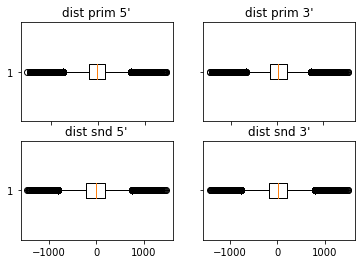

In [242]:
# look at distances
fig, axs = plt.subplots(2, 2)

axs[0, 0].boxplot(library_df["dist prim 5'"], vert=False)
axs[0, 0].set_title("dist prim 5'")
axs[0, 1].boxplot(library_df["dist prim 3'"], vert=False)
axs[0, 1].set_title("dist prim 3'")
axs[1, 0].boxplot(library_df["dist snd 5'"], vert=False)
axs[1, 0].set_title("dist snd 5'")
axs[1, 1].boxplot(library_df["dist snd 3'"], vert=False)
axs[1, 1].set_title("dist snd 3'")

for ax in fig.get_axes():
    ax.label_outer()

These boxplots suggest that there are several outliers among the distances. This may be because of incorrect annotations. We will remove extreme outliers, defined as points that are 3 * IQR away from the first or third quartile.

In [243]:
q75_prim5, q25_prim5 = np.percentile(library_df["dist prim 5'"], [75 ,25])
q75_prim3, q25_prim3 = np.percentile(library_df["dist prim 3'"], [75 ,25])
q75_snd5, q25_snd5 = np.percentile(library_df["dist snd 5'"], [75 ,25])
q75_snd3, q25_snd3 = np.percentile(library_df["dist snd 3'"], [75 ,25])

iqr_prim5 = q75_prim5 - q25_prim5
iqr_prim3 = q75_prim3 - q25_prim3
iqr_snd5 = q75_snd5 - q25_snd5
iqr_snd3 = q75_snd3 - q25_snd3

In [244]:
mult = 3

mask_prim5 = np.logical_or(library_df["dist prim 5'"] < q25_prim5 - mult * iqr_prim5, 
                           library_df["dist prim 5'"] > q75_prim5 + mult * iqr_prim5)

mask_prim3 = np.logical_or(library_df["dist prim 3'"] < q25_prim3 - mult * iqr_prim3, 
                           library_df["dist prim 3'"] > q75_prim3 + mult * iqr_prim3)

mask_snd5 = np.logical_or(library_df["dist snd 5'"] < q25_snd5 - mult * iqr_snd5, 
                          library_df["dist snd 5'"] > q75_snd5 + mult * iqr_snd5)

mask_snd3 = np.logical_or(library_df["dist snd 3'"] < q25_snd3 - mult * iqr_snd3, 
                          library_df["dist snd 3'"] > q75_snd3 + mult * iqr_snd3)

mask_sum = (mask_prim5 * 1) + (mask_prim3 * 1) + (mask_snd5 * 1) + (mask_snd3 * 1)

Number of extreme outliers: 100


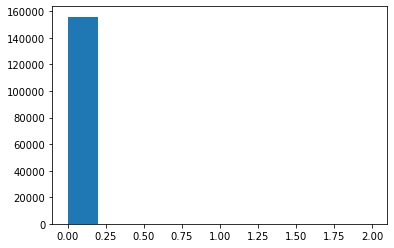

In [245]:
plt.hist(mask_sum)
print("Number of extreme outliers: " + str(sum(mask_sum != 0)))

In [246]:
library_df = library_df.loc[mask_sum == 0].reset_index().drop(columns=['index'])

In [247]:
library_df

,sequence,predicted score v2,predicted score v2.1,gene,strand,coordinate,length,+ve strand,dist prim 5',dist prim 3',dist snd 5',dist snd 3'
0,GAGAGATCCCCACCCGGAAA,0.628753,0.637224,A1CF,-,52645373,23,0,6,20,6,20
1,GGGGATCTCTGAAATTACTC,0.626302,0.690343,A1CF,+,52645339,23,1,40,54,40,54
2,GGAGTGCCTGTCCCAATCCT,0.618647,0.498248,A1CF,+,52645000,23,1,379,393,379,393
3,GACCACGGAGGGTTCAAGAG,0.599543,0.589738,A1CF,+,52645080,23,1,299,313,299,313
4,GTTCTCAGGGTCCTAGGATT,0.597853,0.476740,A1CF,-,52645011,23,0,368,382,368,382
...,...,...,...,...,...,...,...,...,...,...,...,...
155909,GGACCCACCTGGAAGCGCCG,0.851347,0.796605,ZZZ3,+,78149066,23,1,-25,76,-742,-701
155910,GTCCACTAGACCCAACATGG,0.850643,0.639875,ZZZ3,-,78148422,23,0,619,720,-98,-57
155911,GTGTGCGCGGGCGAAAGGGG,0.807459,0.567739,ZZZ3,+,78148719,23,1,322,423,-395,-354
155912,GGATTCTCGCGGGACCTCGT,0.799355,0.718886,ZZZ3,+,78148338,23,1,703,804,-14,27


---

# Feature: Longest Consecutive Run of Each Base 

In [248]:
def get_longest_consec(seq):
    """
    The function finds the longest consecutive run of each
    nucleotide base within a sequence in O(n).
    
    Args:
        seq (str): The sgRNA sequence.

    Returns:
        4-tuple: the entries are the longest consecutive
        run of 'A', 'C', 'G', and 'T' in that order.
    """
    
    max_run = {'A': 0, 'C': 0, 'G': 0, 'T': 0}
    current_run = 0
    current_base = None

    for char in seq:
        if char == current_base:
            current_run += 1
        else:
            if current_base != None and current_run > max_run[current_base]:
                max_run[current_base] = current_run
            current_base = char
            current_run = 1
            
    return (max_run['A'], max_run['C'], max_run['G'], max_run['T'])

In [249]:
longest_consec_run_colnames = [
    'longest A',
    'longest C', 
    'longest G', 
    'longest T'
]

longest_consec_run_series = library_df['sequence'].apply(get_longest_consec)

longest_consec_run_df = pd.DataFrame(longest_consec_run_series.tolist(), columns = longest_consec_run_colnames)

library_df = pd.concat([library_df, longest_consec_run_df], axis=1, sort=False)
library_df

,sequence,predicted score v2,predicted score v2.1,gene,strand,coordinate,length,+ve strand,dist prim 5',dist prim 3',dist snd 5',dist snd 3',longest A,longest C,longest G,longest T
0,GAGAGATCCCCACCCGGAAA,0.628753,0.637224,A1CF,-,52645373,23,0,6,20,6,20,1,4,2,1
1,GGGGATCTCTGAAATTACTC,0.626302,0.690343,A1CF,+,52645339,23,1,40,54,40,54,3,1,4,2
2,GGAGTGCCTGTCCCAATCCT,0.618647,0.498248,A1CF,+,52645000,23,1,379,393,379,393,2,3,2,1
3,GACCACGGAGGGTTCAAGAG,0.599543,0.589738,A1CF,+,52645080,23,1,299,313,299,313,2,2,3,2
4,GTTCTCAGGGTCCTAGGATT,0.597853,0.476740,A1CF,-,52645011,23,0,368,382,368,382,1,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155909,GGACCCACCTGGAAGCGCCG,0.851347,0.796605,ZZZ3,+,78149066,23,1,-25,76,-742,-701,2,3,2,1
155910,GTCCACTAGACCCAACATGG,0.850643,0.639875,ZZZ3,-,78148422,23,0,619,720,-98,-57,2,3,1,1
155911,GTGTGCGCGGGCGAAAGGGG,0.807459,0.567739,ZZZ3,+,78148719,23,1,322,423,-395,-354,3,1,3,1
155912,GGATTCTCGCGGGACCTCGT,0.799355,0.718886,ZZZ3,+,78148338,23,1,703,804,-14,27,1,2,3,2


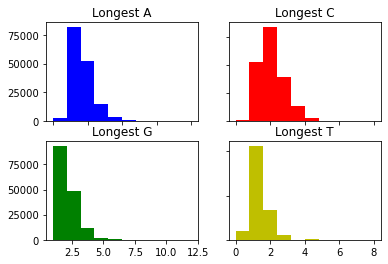

In [250]:
# look at longest consecutive run
fig, axs = plt.subplots(2, 2)

axs[0, 0].hist(library_df['longest A'], color="b")
axs[0, 0].set_title('Longest A')
axs[0, 1].hist(library_df['longest C'], color="r")
axs[0, 1].set_title('Longest C')
axs[1, 0].hist(library_df['longest G'], color="g")
axs[1, 0].set_title('Longest G')
axs[1, 1].hist(library_df['longest T'], color="y")
axs[1, 1].set_title('Longest T')

for ax in fig.get_axes():
    ax.label_outer()

---

# Feature: sgRNA Length

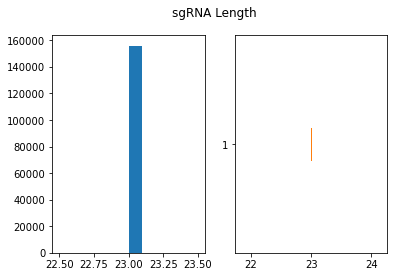

In [251]:
fig, axs = plt.subplots(1, 2)
fig.suptitle("sgRNA Length")


axs[0].hist(library_df['length'])
axs[1].boxplot(library_df['length'], vert=False)

plt.show()

---

# Feature: Nucleotides at Each Position

To maintain the nucleotide at each position, we will create a new dataframe with one row for every sgRNA sequence in `activity_scores_df` and one column for each position in the longest sequence. Necessarily, some cells will have empty spaces since not all sequences are of equal length.

In [254]:
# get each sequence as a string of the same length, right justified
max_len = 25
sequence_rjust = library_df['sequence'].apply(lambda x : x.rjust(max_len))

In [255]:
sgRNA_bases = pd.DataFrame(sequence_rjust.apply(list).tolist())
sgRNA_bases['length'] = library_df['sequence'].str.len()
sgRNA_bases.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,length
0,,,,,,G,A,G,A,G,...,A,C,C,C,G,G,A,A,A,20
1,,,,,,G,G,G,G,A,...,A,A,A,T,T,A,C,T,C,20
2,,,,,,G,G,A,G,T,...,C,C,C,A,A,T,C,C,T,20
3,,,,,,G,A,C,C,A,...,G,T,T,C,A,A,G,A,G,20
4,,,,,,G,T,T,C,T,...,C,C,T,A,G,G,A,T,T,20


In [256]:
nucl_prefix = dict()

for i in range(max_len):
    nucl_prefix[i] = "pos_-" + str(max_len - 1 - i + 3) # add'l 3 b/c PAM

In [257]:
a = pd.DataFrame([25 * ['A'] + [0]], columns=sgRNA_bases.columns.tolist())
c = pd.DataFrame([25 * ['C'] + [0]], columns=sgRNA_bases.columns.tolist())
g = pd.DataFrame([25 * ['G'] + [0]], columns=sgRNA_bases.columns.tolist())
t = pd.DataFrame([25 * ['T'] + [0]], columns=sgRNA_bases.columns.tolist())
nucl_tmp = sgRNA_bases.append(a).append(c).append(g).append(t).replace(' ', np.nan)

In [258]:
nucl_onehot = pd.get_dummies(nucl_tmp, prefix=nucl_prefix, dummy_na = False)
nucl_onehot = nucl_onehot[nucl_onehot['length'] != 0]
nucl_onehot.head()

,length,pos_-27_A,pos_-27_C,pos_-27_G,pos_-27_T,pos_-26_A,pos_-26_C,pos_-26_G,pos_-26_T,pos_-25_A,...,pos_-5_G,pos_-5_T,pos_-4_A,pos_-4_C,pos_-4_G,pos_-4_T,pos_-3_A,pos_-3_C,pos_-3_G,pos_-3_T
0,20,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2,20,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,20,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
4,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [47]:
# base_encodings = {
#     'A' : 0, 
#     'C' : 1, 
#     'G' : 2, 
#     'T' : 3, 
# }

# for base, repl in _base_encodings.items():
#     sgRNA_bases.replace(dimer, repl, inplace = True)
    
# sgRNA_bases.head()

---

# Feature: Nucleotide Composition

In [259]:
As = []
Cs = []
Gs = []
Ts = []

for index, row in sgRNA_bases.iterrows():
    length = row['length']
    As.append(sum(row == 'A') / length)
    Cs.append(sum(row == 'C') / length)
    Gs.append(sum(row == 'G') / length)
    Ts.append(sum(row == 'T') / length)
    
sgRNA_bases['As'] = As
sgRNA_bases['Cs'] = Cs
sgRNA_bases['Gs'] = Gs
sgRNA_bases['Ts'] = Ts

sgRNA_bases.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,length,As,Cs,Gs,Ts
0,,,,,,G,A,G,A,G,...,G,G,A,A,A,20,0.35,0.35,0.25,0.05
1,,,,,,G,G,G,G,A,...,T,A,C,T,C,20,0.25,0.20,0.25,0.30
2,,,,,,G,G,A,G,T,...,A,T,C,C,T,20,0.15,0.35,0.25,0.25
3,,,,,,G,A,C,C,A,...,A,A,G,A,G,20,0.30,0.20,0.40,0.10
4,,,,,,G,T,T,C,T,...,G,G,A,T,T,20,0.15,0.20,0.30,0.35


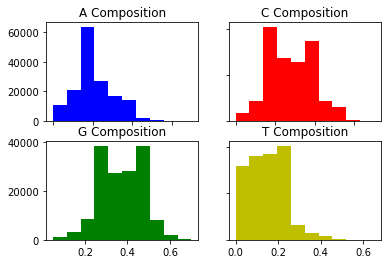

In [260]:
# look at nucleotide composition
fig, axs = plt.subplots(2, 2)

axs[0, 0].hist(sgRNA_bases['As'], color="b")
axs[0, 0].set_title('A Composition')
axs[0, 1].hist(sgRNA_bases['Cs'], color="r")
axs[0, 1].set_title('C Composition')
axs[1, 0].hist(sgRNA_bases['Gs'], color="g")
axs[1, 0].set_title('G Composition')
axs[1, 1].hist(sgRNA_bases['Ts'], color="y")
axs[1, 1].set_title('T Composition')

for ax in fig.get_axes():
    ax.label_outer()

---

# Feature: Dimers at Each Position

Similarly, to maintain the dimer at each position, we will create a new dataframe with one row for every sgRNA sequence in `activity_scores_df` and one column for each dimer position in the longest sequence. Necessarily, some columns will have `None` since not all sequences are of equal length.

In [261]:
def get_seq_dimers(seq):
    """
    This function returns the dimers of an input sequence
    as a list of two-character strings.
    
    Args:
        seq (str): The sgRNA sequence.

    Returns:
        list: the entry at position i is the ith dimer,
        captured as a two-character string.
    """
    return [seq[i:i+2] for i in range(0, len(seq)-1)]

In [262]:
# NOTE BUG: Gettting some single nucleotides at the ends
# If odd number of positions, ignore last guy
max_dimer_len = max_len - 1
sequence_rjust = library_df['sequence'].apply(lambda x : x.rjust(max_len))
sgRNA_dimers = pd.DataFrame(sequence_rjust.apply(get_seq_dimers).tolist())

# subtract one b/c one fewer dimers than bases
sgRNA_dimers['length'] = library_df['sequence'].str.len() - 1

sgRNA_dimers.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,length
0,,,,,G,GA,AG,GA,AG,GA,...,CA,AC,CC,CC,CG,GG,GA,AA,AA,19
1,,,,,G,GG,GG,GG,GA,AT,...,GA,AA,AA,AT,TT,TA,AC,CT,TC,19
2,,,,,G,GG,GA,AG,GT,TG,...,TC,CC,CC,CA,AA,AT,TC,CC,CT,19
3,,,,,G,GA,AC,CC,CA,AC,...,GG,GT,TT,TC,CA,AA,AG,GA,AG,19
4,,,,,G,GT,TT,TC,CT,TC,...,TC,CC,CT,TA,AG,GG,GA,AT,TT,19


In [263]:
prefix = dict()
for i in range(max_dimer_len):
    prefix[i] = "pos_-" + str(max_dimer_len - 1 - i + 4)  # add'l 4 b/c PAM

In [264]:
dimer_encodings = {'AA' : 0, 'AC' : 1, 'AG' : 2, 'AT' : 3, 'CA' : 4, 'CC' : 5, 'CG' : 6, 'CT' : 7,          
                   'GA' : 8, 'GC' : 9, 'GG' : 10, 'GT' : 11, 'TA' : 12, 'TC' : 13, 'TG' : 14, 'TT' : 15}
dummy_dimers = []
tmp = pd.DataFrame()
tmp = tmp.append(sgRNA_dimers)

for dimer in dimer_encodings.keys():
    dummy_dimers.append(pd.DataFrame([max_dimer_len * [dimer] + [0]], columns=sgRNA_dimers.columns.tolist()))
for df in dummy_dimers:
    tmp = tmp.append(df)

incomplete_dimers = ['  ', ' A', ' C', ' G', ' T']
    
tmp = tmp.replace(incomplete_dimers, np.nan)
tmp.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,length
0,NaN,NaN,NaN,NaN,NaN,GA,AG,GA,AG,GA,...,CA,AC,CC,CC,CG,GG,GA,AA,AA,19
1,NaN,NaN,NaN,NaN,NaN,GG,GG,GG,GA,AT,...,GA,AA,AA,AT,TT,TA,AC,CT,TC,19
2,NaN,NaN,NaN,NaN,NaN,GG,GA,AG,GT,TG,...,TC,CC,CC,CA,AA,AT,TC,CC,CT,19
3,NaN,NaN,NaN,NaN,NaN,GA,AC,CC,CA,AC,...,GG,GT,TT,TC,CA,AA,AG,GA,AG,19
4,NaN,NaN,NaN,NaN,NaN,GT,TT,TC,CT,TC,...,TC,CC,CT,TA,AG,GG,GA,AT,TT,19


In [265]:
dimer_onehot = pd.get_dummies(tmp, prefix=prefix, dummy_na = False)
dimer_onehot.head()

,length,pos_-27_AA,pos_-27_AC,pos_-27_AG,pos_-27_AT,pos_-27_CA,pos_-27_CC,pos_-27_CG,pos_-27_CT,pos_-27_GA,...,pos_-4_CG,pos_-4_CT,pos_-4_GA,pos_-4_GC,pos_-4_GG,pos_-4_GT,pos_-4_TA,pos_-4_TC,pos_-4_TG,pos_-4_TT
0,19,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,19,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,19,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,19,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,19,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [266]:
dimer_onehot = dimer_onehot[dimer_onehot['length'] != 0]
dimer_onehot.head()

,length,pos_-27_AA,pos_-27_AC,pos_-27_AG,pos_-27_AT,pos_-27_CA,pos_-27_CC,pos_-27_CG,pos_-27_CT,pos_-27_GA,...,pos_-4_CG,pos_-4_CT,pos_-4_GA,pos_-4_GC,pos_-4_GG,pos_-4_GT,pos_-4_TA,pos_-4_TC,pos_-4_TG,pos_-4_TT
0,19,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,19,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,19,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,19,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,19,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [56]:
# dimer_encodings = {
#     'AA' : 0, 
#     'AC' : 1, 
#     'AG' : 2, 
#     'AT' : 3, 
#     'CA' : 4, 
#     'CC' : 5, 
#     'CG' : 6, 
#     'CT' : 7,          
#     'GA' : 8, 
#     'GC' : 9, 
#     'GG' : 10, 
#     'GT' : 11, 
#     'TA' : 12, 
#     'TC' : 13, 
#     'TG' : 14, 
#     'TT' : 15
# }

# for dimer, repl in encodings.items():
#     sgRNA_dimers.replace(dimer, repl, inplace = True)
    
# sgRNA_dimers.head()

---

# Feature: Dimer Composition

In [267]:
# Relevant dimers that the paper decsribes: GC, CA, AG
GC = []
CA = []
AG = []

for index, row in sgRNA_dimers.iterrows():
    length = row['length']
    GC.append(sum(row == 'GC') / length)
    CA.append(sum(row == 'CA') / length)
    AG.append(sum(row == 'AG') / length)

sgRNA_dimers['GC'] = GC
sgRNA_dimers['CA'] = CA
sgRNA_dimers['AG'] = AG
              
sgRNA_dimers.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,length,GC,CA,AG
0,,,,,G,GA,AG,GA,AG,GA,...,CC,CG,GG,GA,AA,AA,19,0.000000,0.052632,0.105263
1,,,,,G,GG,GG,GG,GA,AT,...,AT,TT,TA,AC,CT,TC,19,0.000000,0.000000,0.000000
2,,,,,G,GG,GA,AG,GT,TG,...,CA,AA,AT,TC,CC,CT,19,0.052632,0.052632,0.052632
3,,,,,G,GA,AC,CC,CA,AC,...,TC,CA,AA,AG,GA,AG,19,0.000000,0.105263,0.157895
4,,,,,G,GT,TT,TC,CT,TC,...,TA,AG,GG,GA,AT,TT,19,0.000000,0.052632,0.105263


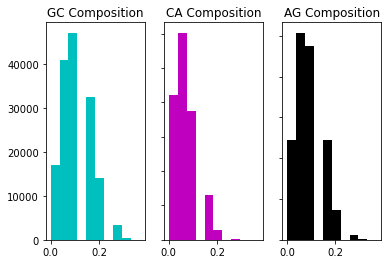

In [268]:
# look at nucleotide composition
fig, axs = plt.subplots(1, 3)

axs[0].hist(sgRNA_dimers['GC'], color="c")
axs[0].set_title('GC Composition')
axs[1].hist(sgRNA_dimers['CA'], color="m")
axs[1].set_title('CA Composition')
axs[2].hist(sgRNA_dimers['AG'], color="k")
axs[2].set_title('AG Composition')

for ax in fig.get_axes():
    ax.label_outer()

---

# Relationship between CRISPRi activity and sgRNA position relative to the TSS as predicted by SVR.

In [276]:
library_df.to_csv("features_hCRISPRi_v2.csv")

In [277]:
SVR_df = pd.read_csv("svr_v2.csv").drop(columns=['Unnamed: 0'])
SVR_df.head()

,dist prim 3',dist prim 5',dist snd 3',dist snd 5'
0,0.566183,0.511548,0.479786,0.470973
1,0.524664,0.382736,0.456344,0.421644
2,0.131578,0.122549,0.197295,0.173416
3,0.280770,0.188223,0.296115,0.271189
4,0.140900,0.119207,0.211015,0.182778


# Make Final Dataframes of all Features

In [286]:
library_df_cols = [
    "predicted score v2.1",
    "+ve strand",
    "length",
    "longest A",
    "longest C",
    "longest G",
    "longest T"
]
library_df_features = library_df[library_df_cols]

sgRNA_bases_cols = [
    "As",
    "Cs",
    "Gs",
    "Ts"
]
sgRNA_bases_features = sgRNA_bases[sgRNA_bases_cols]

sgRNA_dimers_cols = [
    "GC",
    "CA",
    "AG"
]
sgRNA_dimers_features = sgRNA_dimers[sgRNA_dimers_cols]

nucl_onehot_features = nucl_onehot.iloc[:, 1:]
dimer_onehot_features = dimer_onehot.iloc[:, 1:]

SVR_df_features = SVR_df

In [287]:
features_df_list = [
    library_df_features, 
    sgRNA_bases_features, 
    sgRNA_dimers_features, 
    nucl_onehot_features, 
    dimer_onehot_features, 
    SVR_df_features
]
features_df = pd.concat(features_df_list, axis = 1)
features_df.head()

,predicted score v2.1,+ve strand,length,longest A,longest C,longest G,longest T,As,Cs,Gs,...,pos_-4_GG,pos_-4_GT,pos_-4_TA,pos_-4_TC,pos_-4_TG,pos_-4_TT,dist prim 3',dist prim 5',dist snd 3',dist snd 5'
0,0.637224,0,23,1,4,2,1,0.35,0.35,0.25,...,0,0,0,0,0,0,0.566183,0.511548,0.479786,0.470973
1,0.690343,1,23,3,1,4,2,0.25,0.20,0.25,...,0,0,0,1,0,0,0.524664,0.382736,0.456344,0.421644
2,0.498248,1,23,2,3,2,1,0.15,0.35,0.25,...,0,0,0,0,0,0,0.131578,0.122549,0.197295,0.173416
3,0.589738,1,23,2,2,3,2,0.30,0.20,0.40,...,0,0,0,0,0,0,0.280770,0.188223,0.296115,0.271189
4,0.476740,0,23,1,2,3,2,0.15,0.20,0.30,...,0,0,0,0,0,1,0.140900,0.119207,0.211015,0.182778


In [294]:
features_df = features_df.rename(columns={"predicted score v2.1": "score"})

In [297]:
features_df.to_csv("features_hCRISPRi_v2.csv")

In [295]:
features_df

,score,+ve strand,length,longest A,longest C,longest G,longest T,As,Cs,Gs,...,pos_-4_GG,pos_-4_GT,pos_-4_TA,pos_-4_TC,pos_-4_TG,pos_-4_TT,dist prim 3',dist prim 5',dist snd 3',dist snd 5'
0,0.637224,0,23,1,4,2,1,0.35,0.35,0.25,...,0,0,0,0,0,0,0.566183,0.511548,0.479786,0.470973
1,0.690343,1,23,3,1,4,2,0.25,0.20,0.25,...,0,0,0,1,0,0,0.524664,0.382736,0.456344,0.421644
2,0.498248,1,23,2,3,2,1,0.15,0.35,0.25,...,0,0,0,0,0,0,0.131578,0.122549,0.197295,0.173416
3,0.589738,1,23,2,2,3,2,0.30,0.20,0.40,...,0,0,0,0,0,0,0.280770,0.188223,0.296115,0.271189
4,0.476740,0,23,1,2,3,2,0.15,0.20,0.30,...,0,0,0,0,0,1,0.140900,0.119207,0.211015,0.182778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155909,0.796605,1,23,2,3,2,1,0.20,0.40,0.35,...,0,0,0,0,0,0,0.450238,0.564897,0.222314,0.235245
155910,0.639875,0,23,2,3,1,1,0.30,0.35,0.20,...,1,0,0,0,0,0,0.117834,0.100199,0.371725,0.361273
155911,0.567739,1,23,3,1,3,1,0.15,0.15,0.60,...,1,0,0,0,0,0,0.128063,0.145081,0.235245,0.225251
155912,0.718886,1,23,1,2,3,2,0.10,0.30,0.35,...,0,1,0,0,0,0,0.095720,0.110042,0.479029,0.479935
